In [68]:
import model_def
import parameters_def 
import process_data_IFFL
all_params = parameters_def.main()

from utils import *
import numpy as np
from lmfit import minimize
import tellurium as te
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import time
from multiprocessing import Pool

(0.0, 700.0)

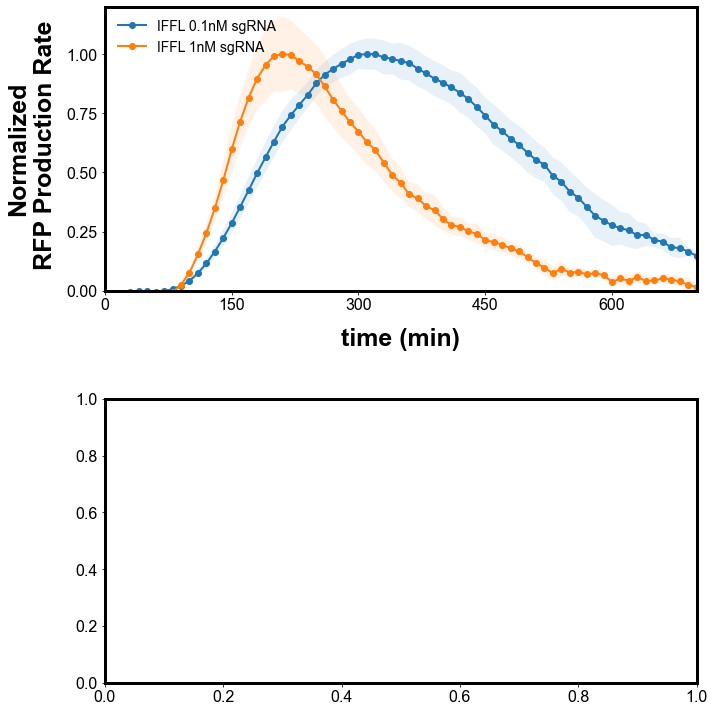

In [69]:
# get the data

ax, nmeans, nstds = process_data_IFFL.get_data(plot=True, exps =[2,6])
ax.set_xlim([0,700])

In [70]:
# get the model

rr = te.loada(model_def.large_model.format(*np.zeros(len(model_def.large_model_params))))

In [71]:
# get the parameters and specify experimental conditions

vparams = all_params['large_model_p']
fparams = Params()
fparams.add('RFP_t0', 4, vary = False)
fparams.add('scRNA_t0', 16, vary = False)
fparams.add('gRNA_t0', 1, vary = False)
fparams.add('dCas9_t0', 2, vary = False)
fparams.add('SoxS_t0', 4, vary = False)
ordered_p = rr.getGlobalParameterIds()
vparams = vparams.reorder(ordered_p)
init_indexes = []
for p in fparams:
    if not fparams[p].vary:
        init_indexes.append(*[i for i,v in enumerate('['+p[:-3]+'_DNA]' in i for i in rr.model.getFloatingSpeciesInitConcentrationIds()) if v])        

index = 'gRNA_t0'
exps = {1: 1, 0: 0.1}

In [72]:
# sample the parameter space

R = 1000
data_to_fit = np.random.randint(nmeans.shape[1],size = R)
prior = vparams.sample('log-uniform', (R,))
prior = np.log(prior)
vparams.transformBounds(np.log)

In [73]:
def normalized_prod_rate(sol):
    return np.diff(sol[:,3])/np.max(np.diff(sol[:,3]))

In [74]:
def nfit(vparams, fparams, parameters, data, error, to_fit, cross_val = True):
    fitted_parameters = np.zeros(parameters.shape)
    chis = np.zeros(parameters.shape[0])
    cv = np.zeros(parameters.shape[0])
        
    def minimize_cv(parameters):
        for i in range(parameters.shape[0]):
            train = data[:,to_fit[i],np.newaxis]
            train_error = error[:,to_fit[i],np.newaxis]
            test_index = np.where(np.arange(data.shape[1])!=to_fit[i])[0]
            test = data[:,test_index] 
            test_error =  error[:,test_index] 
            vparams.setValues(parameters[i,:])
            out = minimize(residual, vparams, \
                           args=(fparams, train, train_error, [to_fit[i]], normalized_prod_rate),\
                                 nan_policy='omit',method='Nelder-Mead', options = {'adaptive': True})
            fitted_parameters[i,] = out.params.getValues()
            chis[i] = out.chisqr
            if cross_val:
                cv[i] = np.nansum(residual(vparams, fparams, test, test_error, test_index, transform_f = normalized_prod_rate)**2)/test.shape[1]
        if cross_val: return fitted_parameters, chis, cv
        return fitted_parameters, chis
    return minimize_cv(parameters)

In [75]:
def residual(vparams, fparams, data = None, error= None, exp_index = None, transform_f = None, returnvar = 'res'):
    vary_params = np.exp(np.array(vparams))
    fit = np.zeros(data.shape)
    points = len(data)+1
    rr.timeCourseSelections = ['time','[scRNA]','[gRNA]','[RFP_ON]','[CRISPRa]']
    rr.model.setGlobalParameterValues(vary_params)
    
    for i in range(data.shape[1]):
        fparams[index].value = exps[exp_index[i]]
        rr.reset()
        rr.model.setFloatingSpeciesInitConcentrations(np.array(init_indexes), fparams.getValues())
        try:
            sol = rr.simulate(0,60*points*10,points)
            if transform_f: sol = transform_f(sol)
        except RuntimeError as error:
            print('Catched an error while running the simulation! \n')
            print(error)
            print('\n returning zeros')
            sol = np.zeros(len(data))
            
        fit[:,i] = sol
        
    if returnvar == 'model':
        return fit
    if returnvar == 'res':
        return (fit-data) #/(error + 1e-8)

In [76]:
start = time.time()
fitted, chis, cv = nfit(vparams, fparams, prior, nmeans.to_numpy(),nstds.to_numpy(), data_to_fit)
end = time.time()
print(end-start)

5232.6411600112915


In [77]:
with open("results_2_6.dat", "wb") as output_file:
    pickle.dump([fitted,chis,cv,vparams,fparams,prior,nmeans,nstds,data_to_fit],output_file)

In [78]:
with open("results_2_6.dat", "rb") as input_file:
    fitted,chis,cv,vparams,fparams,prior,nmeans,nstds,data_to_fit = pickle.load(input_file)

In [79]:
fparams

name,value,initial value,min,max,vary
RFP_t0,4.00000000,4,-inf,inf,False
scRNA_t0,16.0000000,16,-inf,inf,False
gRNA_t0,1.00000000,1,-inf,inf,False
dCas9_t0,2.00000000,2,-inf,inf,False
SoxS_t0,4.00000000,4,-inf,inf,False


In [80]:
def nbest(a1, a2, N):
    best = []; i =1
    while len(best) < N:
        best = np.intersect1d(np.argsort(a1)[:i], np.argsort(a2)[:i])
        i+=1
    return best

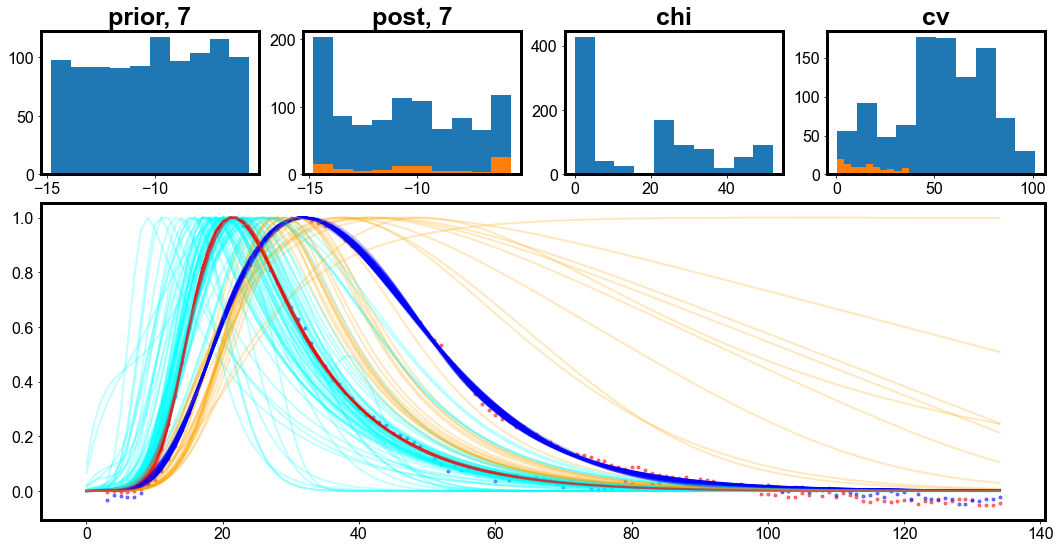

In [81]:
showp = 7

N = 100
best = nbest(chis,cv,N)
    
fig = plt.figure(figsize=(18, 9))
grid = plt.GridSpec(3, 4, hspace=0.2, wspace=0.2)

plt.subplot(grid[0,0])
plt.hist((prior[:,showp]))
plt.title('prior, '+str(showp))

plt.subplot(grid[0,1])
plt.hist(fitted[:,showp])
plt.hist(fitted[best,showp])
plt.title('post, '+str(showp))

plt.subplot(grid[0,2])
plt.hist((chis))
plt.hist((chis[best]))
plt.title('chi')

plt.subplot(grid[0,3])
plt.hist((cv))
plt.hist((cv[best]))
plt.title('cv')

plt.subplot(grid[1:,:])
plt.plot(nmeans['2'].to_numpy(),'r.', alpha = 0.5, label = 'data')
plt.plot(nmeans['6'].to_numpy(),'b.', alpha = 0.5, label = 'data')

for i in best:
    train = nmeans.to_numpy()[:,data_to_fit[i],np.newaxis]
    test_index = np.where(np.arange(len(exps))!=data_to_fit[i])[0]
    test = nmeans.to_numpy()[:,test_index]
    vparams.setValues(fitted[i,:])
    if data_to_fit[i] == 0:
        plt.plot(residual(vparams, fparams, train, exp_index=[data_to_fit[i]], transform_f=normalized_prod_rate,returnvar='model'),'b', label = 'model, fit', alpha = 0.25)
        plt.plot(residual(vparams, fparams, test, exp_index=test_index, transform_f=normalized_prod_rate,returnvar='model'),'cyan', label = 'model, fit', alpha = 0.25)
    if data_to_fit[i] == 1:
        plt.plot(residual(vparams, fparams, train, exp_index=[data_to_fit[i]], transform_f=normalized_prod_rate,returnvar='model'),'r', label = 'model, fit', alpha = 0.25)
        plt.plot(residual(vparams, fparams, test, exp_index=test_index, transform_f=normalized_prod_rate,returnvar='model'),'orange', label = 'model, fit', alpha = 0.25)


In [100]:
n = 25
alltrain = np.zeros((len(nmeans),1,n,nmeans.shape[1]))
alltest = np.zeros((len(nmeans),nmeans.shape[1]-1,n,nmeans.shape[1]))

for i in range(nmeans.shape[1]):
    ids = data_to_fit==i
    best = nbest(chis[ids],cv[ids],n)
    train = nmeans.to_numpy()[:,i,np.newaxis]
    test_index = np.where(np.arange(len(exps))!=i)[0]
    test = nmeans.to_numpy()[:,test_index]
    for k in range(n):
        vparams.setValues(fitted[ids][best[k],:])
        alltrain[:,:,k,i] = residual(vparams, fparams, train, None, [i], normalized_prod_rate,'model')
        alltest[:,:,k,i] = residual(vparams, fparams, test, None, test_index, normalized_prod_rate,'model')


#42adf5
orange


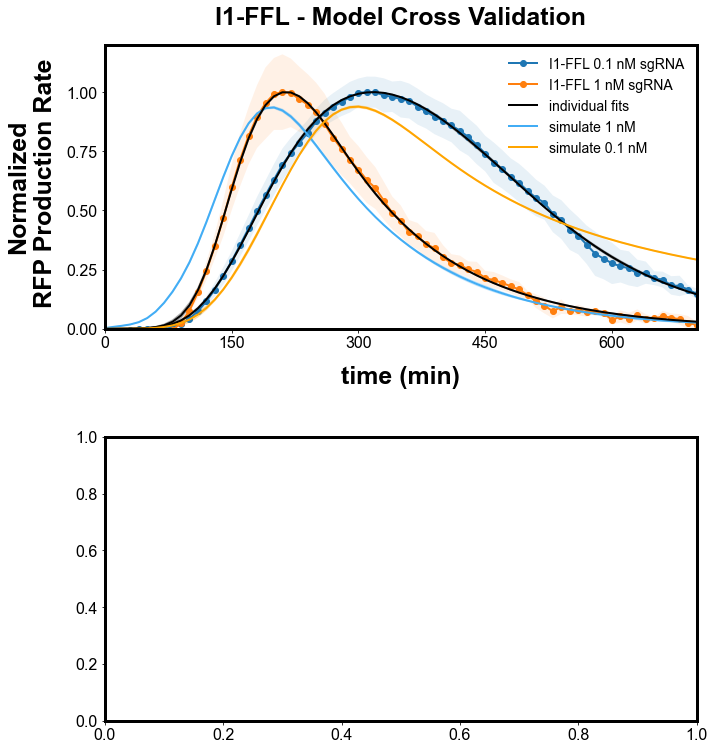

In [118]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['figure.figsize'] = 11,12

ax,_,_ = process_data_IFFL.get_data(plot=True, exps = [2,6])
t = nmeans.index
c = ['#42adf5','orange']
flabel = ['fit','_nolegend_']
for i in range(nmeans.shape[1]):
    train_mean = np.mean(alltrain[:,:,:,i],axis = 2).squeeze()
    train_std = np.std(alltrain[:,:,:,i],axis = 2).squeeze()
    
    ax.plot(t,train_mean,'k', label = flabel[i])
    ax.fill_between(t, train_mean-train_std, train_mean+train_std, color = 'k',alpha = 0.25)
    
    for k in range(nmeans.shape[1]-1):
        print(c[i])
        test_mean = np.mean(alltest[:,k,:,i],axis = 1).squeeze()
        test_std = np.std(alltest[:,k,:,i],axis = 1).squeeze()
        
        ax.plot(t,test_mean,c[i])
        ax.fill_between(t, test_mean-train_std, test_mean+train_std, color = c[i],alpha = 0.25)

ax.set_xlim([0,700])
ax.legend(['I1-FFL 0.1 nM sgRNA','I1-FFL 1 nM sgRNA','individual fits','simulate 1 nM','simulate 0.1 nM'], loc = 'upper right', frameon = False, prop = dict(size=14))   
ax.set_title('I1-FFL - Model Cross Validation', pad = 20)
plt.gca()
plt.savefig('210505_FigS8.svg')

r


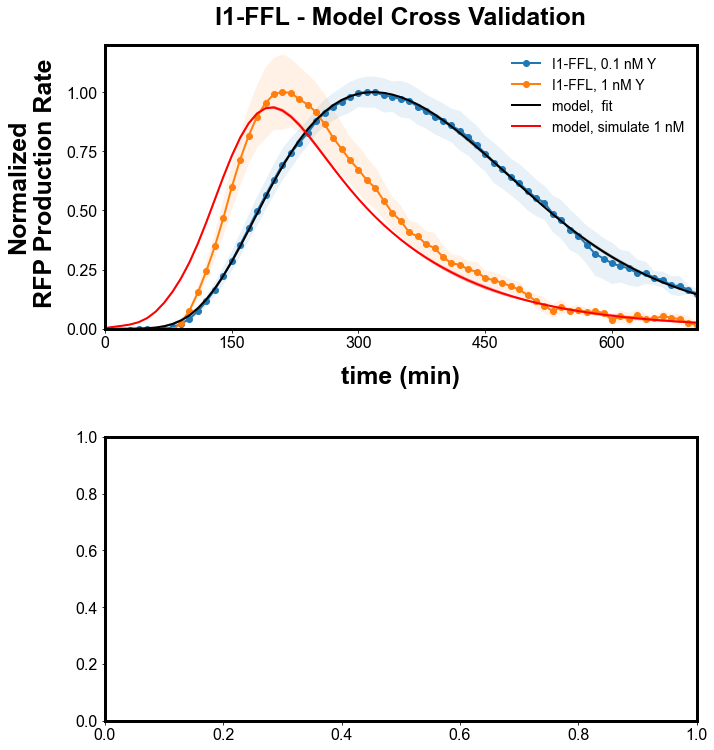

In [117]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['figure.figsize'] = 11,12

ax,_,_ = process_data_IFFL.get_data(plot=True, exps = [2,6])
t = nmeans.index
c = ['r']
flabel = ['fit','_nolegend_']
for i in range(1):
    train_mean = np.mean(alltrain[:,:,:,i],axis = 2).squeeze()
    train_std = np.std(alltrain[:,:,:,i],axis = 2).squeeze()
    
    ax.plot(t,train_mean,'k', label = flabel[i])
    ax.fill_between(t, train_mean-train_std, train_mean+train_std, color = 'k',alpha = 0.25)
    
    for k in range(nmeans.shape[1]-1):
        print(c[i])
        test_mean = np.mean(alltest[:,k,:,i],axis = 1).squeeze()
        test_std = np.std(alltest[:,k,:,i],axis = 1).squeeze()
        
        ax.plot(t,test_mean,c[i])
        ax.fill_between(t, test_mean-train_std, test_mean+train_std, color = c[i],alpha = 0.25)

ax.set_xlim([0,700])
ax.legend(['I1-FFL, 0.1 nM Y','I1-FFL, 1 nM Y','model,  fit','model, simulate 1 nM'], loc = 'upper right', frameon = False, prop = dict(size=14))   
ax.set_title('I1-FFL - Model Cross Validation', pad = 20)
plt.gca()
plt.savefig('210505_Fig3B.svg')